## Setting the covariance matrix with GaussianCovariance code

In [1]:
from scipy.special import legendre
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import LE3_GC_ProductReader as pr
from GaussianCovariance import *
from webdav3.client import Client
import matplotlib.pyplot as plt
from LE3_GC_ProductReader import DpdLE3GCTable
import scipy
import camb

setting general parameters

In [2]:
l_list = [0,2]

In [3]:
rad_edges = np.linspace(0, 200, 41) 
r_bins = (rad_edges[:-1] + rad_edges[1:] ) * 0.5

In [4]:
xi_covariance = TwoPointGaussianCovariance(rad_edges, l_list, deg=51, deg_k=10) 

Computing Bessels functions...
Done!


## BOSS fiducial cosmology

To create the covariance matrix I need a clustering signal-> I use CAMB to generate a power spectrum with BOSS fiducial cosmology

In [5]:
omb_fid = 0.048
h_fid = 0.676
omc_fid = 0.31 - omb_fid
sigma8_fid = 0.824

In [6]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=100*h_fid, ombh2=omb_fid*h_fid**2, omch2=omc_fid*h_fid**2)
pars.set_matter_power(redshifts=[0.], kmax=2.0)
results = camb.get_results(pars)
sigma8=camb.get_results(pars).get_sigma8()
pars.InitPower.set_params(As=2e-9*sigma8_fid**2/sigma8**2, ns=0.965)
pars.set_matter_power(redshifts=[0.38], kmax=2.0)
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=2.0, npoints = 200)

In [7]:
results.get_sigma8()

array([0.67622907])

In [8]:
P = scipy.interpolate.interp1d(kh, pk[0], kind='cubic', fill_value='extrapolate')

In [9]:
f = results.get_fsigma8()/results.get_sigma8()

In [35]:
f

array([0.71587359])

I create a covariance matrix for each subcatalogue. 

I need the mean number density and the volume of the survey. I find the mean number density from the shot noise term. I computed the pk with shot noise and without, subtracting them I find the shot noise term. Inverting it I find the number density. Dividing the total number of objects by the number density i comput eht volume of the survey

## NGZ1

In [11]:
nd_ngz1 = 0.000264
n_obj_ngz1= 429182
V_ngz1 = n_obj_ngz1/nd_ngz1

In [14]:
filename = '../BOSS_results/public_material_RSD/Beutleretal_pk_monopole_DR12_NGC_z1_prerecon_120.dat'

In [15]:
data = np.loadtxt(filename, skiprows=30)

In [16]:
k_boss = data[:,0]
P_boss = data[:,2]
sigma_boss = data[:,3]

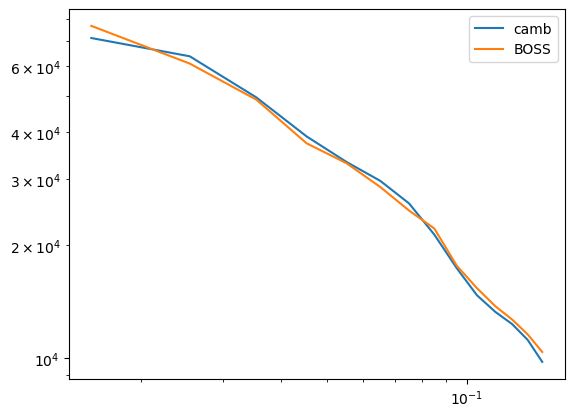

In [56]:
b1 = 2.05
plt.loglog(k_boss, b1**2*P(k_boss), label='camb')
plt.loglog(k_boss, P_boss, label='BOSS')
plt.legend()

I make some tests to find the best value of b1 and f, 

In [75]:
f = 0 
b1 = 2.05
 
p_k_mu = lambda k, mu : (b1 + f * mu**2) **2 * P(k)

In [76]:
f1 = 0.71
b = 1.8


p_k_mu_f = lambda k, mu : (b + f1 * mu**2) **2 * P(k)

In [77]:
deg = 51

mu, weights = np.polynomial.legendre.leggauss(deg)

In [78]:
k = np.load('../npy_pk/k_bins.npy')

In [79]:
p_k_l ={}
for ll in l_list:
    leg = legendre(ll)(mu)
    p_k_l[ll] = 0.5 * (2*ll+1) * np.array([np.sum(weights * p_k_mu(k, mu) * leg)  for k in k]) 

In [80]:
p_k_l_f ={}
for ll in l_list:
    leg = legendre(ll)(mu)
    p_k_l_f[ll] = 0.5 * (2*ll+1) * np.array([np.sum(weights * p_k_mu_f(k, mu) * leg)  for k in k])

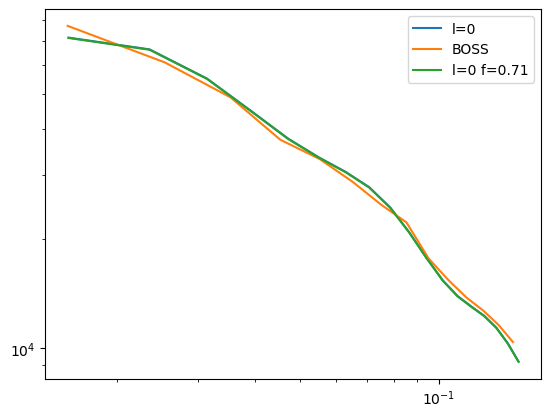

In [81]:
plt.loglog(k, p_k_l[0], label='l=0')
plt.loglog(k_boss, P_boss, label='BOSS')
plt.loglog(k, p_k_l_f[0], label='l=0 f=0.71')
plt.legend()

In [82]:
dk = k[1] - k[0]
k_edges = np.append(k - dk/2, k[-1] + dk/2)

In [83]:
cov_pk_Nz1 = PowerSpectrumGaussianCovariance(k_edges, l_list, deg=51)(p_k_mu, V_ngz1, nd_ngz1) 

/home/lentini/miniconda3/envs/pk/lib/python3.9/site-packages/GaussianCovariance/gaussian_covariance.py:84: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 2 * (2 * np.pi) ** 4 * quad(integrand, k_min, k_max, epsrel=1.e-4, epsabs=0)[0] / k_volume ** 2


In [84]:
cov_pk_Nz1_f = PowerSpectrumGaussianCovariance(k_edges, l_list, deg=51)(p_k_mu_f, V_ngz1, nd_ngz1)

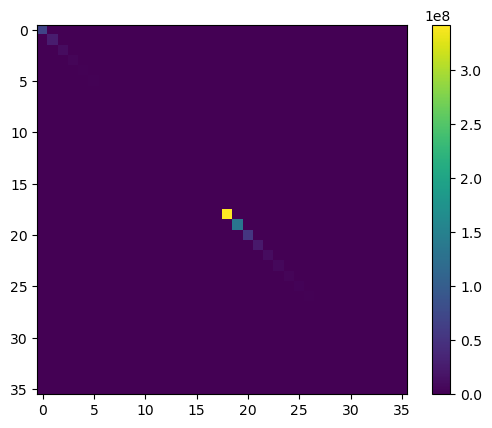

In [85]:
plt.imshow(cov_pk_Nz1)
plt.colorbar()

In [86]:
std_pk_Nz1 = np.sqrt(np.diag(cov_pk_Nz1))
std_pk_Nz1_f = np.sqrt(np.diag(cov_pk_Nz1_f))

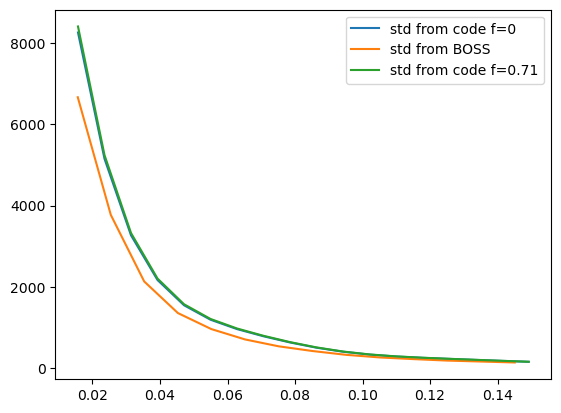

In [87]:
plt.plot(k, std_pk_Nz1[:len(k)], label='std from code f=0')
plt.plot(k_boss, sigma_boss, label='std from BOSS')
plt.plot(k, std_pk_Nz1_f[:len(k)], label='std from code f=0.71')
plt.legend()

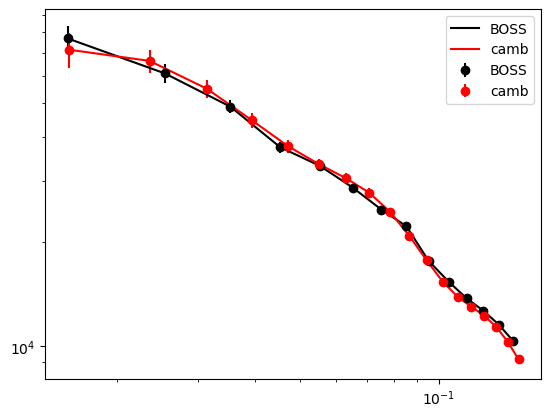

In [88]:
plt.errorbar(k_boss, P_boss, yerr=sigma_boss, fmt='o', label='BOSS', color='black')
plt.errorbar(k, b1**2*P(k), yerr=std_pk_Nz1[:len(k)], fmt='o', label='camb', color='red')
plt.plot(k_boss, P_boss, label='BOSS', color='black')
plt.plot(k, b1**2*P(k), label='camb', color='red')

plt.xscale('log')
plt.yscale('log')
plt.legend()

## QUADRUPOLE

In [89]:
filename = '../BOSS_results/public_material_RSD/Beutleretal_pk_quadrupole_DR12_NGC_z1_prerecon_120.dat'

In [90]:
data = np.loadtxt(filename, skiprows=30)

In [91]:
k2_boss = data[:,0]
P2_boss = data[:,2]
sigma2_boss = data[:,3]

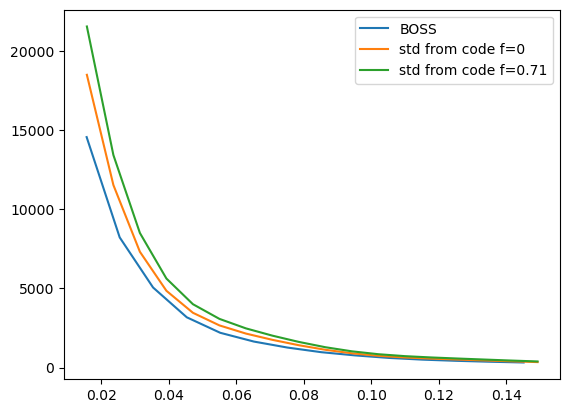

In [92]:
plt.plot(k2_boss, sigma2_boss, label='BOSS')
plt.plot(k, std_pk_Nz1[len(k):], label='std from code f=0')
plt.plot(k, std_pk_Nz1_f[len(k):], label='std from code f=0.71')
plt.legend()

# NGC Z3

In [155]:
nd_ngcz3 =0.000128
n_obj_ngcz3= 435741
V_ngcz3 = n_obj_ngcz3/nd_ngcz3

In [156]:
filename = '../BOSS_results/public_material_RSD/Beutleretal_pk_monopole_DR12_NGC_z3_prerecon_120.dat'

In [157]:
data = np.loadtxt(filename, skiprows=30)
k_boss = data[:,0]
P_boss = data[:,2]
sigma_boss = data[:,3]

In [158]:
b1 = 1.95

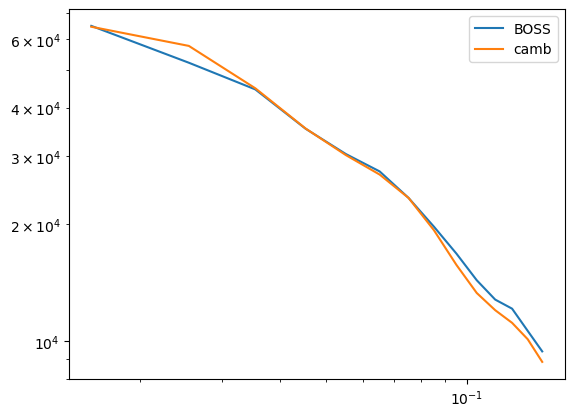

In [159]:
plt.loglog(k_boss, P_boss, label='BOSS')
plt.loglog(k_boss, b1**2*P(k_boss), label='camb')
plt.legend()

In [160]:
f = 0
b1 = 1.95
#beta = f/b1

p_k_mu = lambda k, mu : (b1 + f * mu**2) **2 * P(k)

In [161]:
f1 = 0.71
b = 1.89

p_k_mu_f = lambda k, mu : (b + f1 * mu**2) **2 * P(k)

In [162]:
cov_pk_Nz3 = PowerSpectrumGaussianCovariance(k_edges, l_list, deg=51)(p_k_mu, V_ngcz3, nd_ngcz3) 

In [163]:
cov_pk_Nz3_f = PowerSpectrumGaussianCovariance(k_edges, l_list, deg=51)(p_k_mu_f, V_ngcz3, nd_ngcz3)

In [164]:
std_pk_Nz3= np.sqrt(np.diag(cov_pk_Nz3))
std_pk_Nz3_f = np.sqrt(np.diag(cov_pk_Nz3_f))

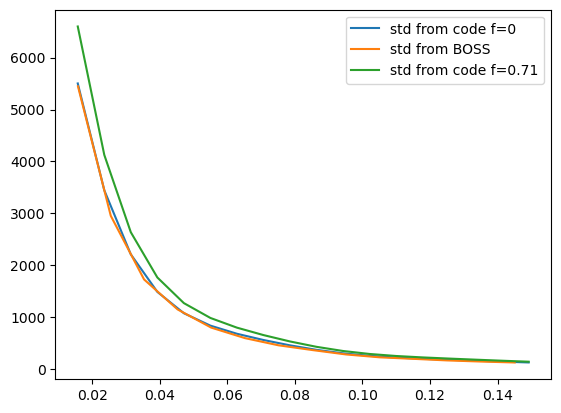

In [165]:
plt.plot(k, std_pk_Nz3[:len(k)], label='std from code f=0')
plt.plot(k_boss, sigma_boss, label='std from BOSS')
plt.plot(k, std_pk_Nz3_f[:len(k)], label='std from code f=0.71')
plt.legend()

# SGC Z1

In [177]:
nd_sgz1 = 2.87e-4 #I found it compute the pk with and without this factor
n_obj_sgz1 = 174819
V_sgz1 = n_obj_sgz1/nd_sgz1

In [178]:
filename = '../BOSS_results/public_material_RSD/Beutleretal_pk_monopole_DR12_SGC_z1_prerecon_120.dat'

In [179]:
data = np.loadtxt(filename, skiprows=30)

In [180]:
k_boss = data[:,0]
P_boss = data[:,2]
sigma_boss = data[:,3]

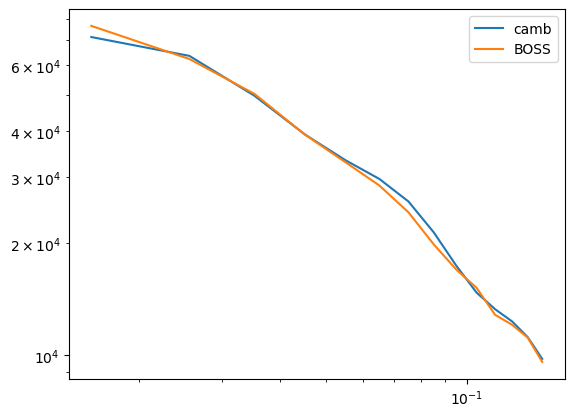

In [181]:
b1 = 2.05
plt.loglog(k_boss, b1**2*P(k_boss), label='camb')
plt.loglog(k_boss, P_boss, label='BOSS')
plt.legend()

In [194]:
f = 0
b1 = 2.05
#beta = f/b1

p_k_mu = lambda k, mu : (b1 + f * mu**2) **2 * P(k)

In [195]:
f1 = 0.71
b = 1.89

p_k_mu_f = lambda k, mu : (b + f1 * mu**2) **2 * P(k)

In [196]:
cov_pk_Sz1 = PowerSpectrumGaussianCovariance(k_edges, l_list, deg=51)(p_k_mu, V_sgz1, nd_sgz1) 

In [197]:
cov_pk_Sz1_f = PowerSpectrumGaussianCovariance(k_edges, l_list, deg=51)(p_k_mu_f, V_sgz1, nd_sgz1)

In [198]:
std_pk_Sz1 = np.sqrt(np.diag(cov_pk_Sz1))
std_pk_Sz1_f = np.sqrt(np.diag(cov_pk_Sz1_f))

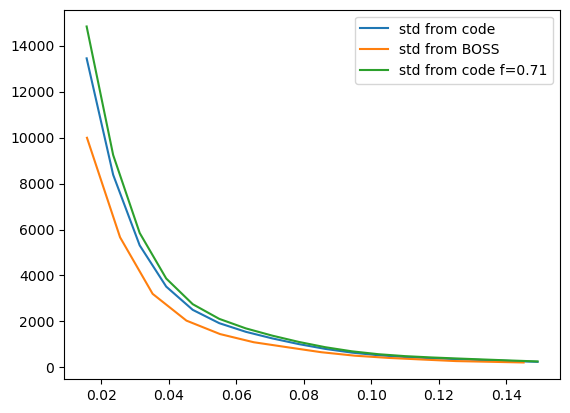

In [199]:
plt.plot(k, std_pk_Sz1[:len(k)], label='std from code')
plt.plot(k_boss, sigma_boss, label='std from BOSS')
plt.plot(k, std_pk_Sz1_f[:len(k)], label='std from code f=0.71')
plt.legend()

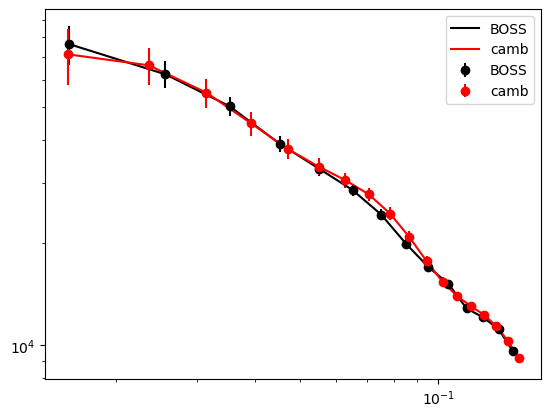

In [200]:
plt.errorbar(k_boss, P_boss, yerr=sigma_boss, fmt='o', label='BOSS', color='black')
plt.errorbar(k, b1**2*P(k), yerr=std_pk_Sz1[:len(k)], fmt='o', label='camb', color='red')
plt.plot(k_boss, P_boss, label='BOSS', color='black')
plt.plot(k, b1**2*P(k), label='camb', color='red')

plt.xscale('log')
plt.yscale('log')
plt.legend()

## QUADRUPOLE

In [202]:
filename = '../BOSS_results/public_material_RSD/Beutleretal_pk_quadrupole_DR12_SGC_z1_prerecon_120.dat'

In [203]:
data = np.loadtxt(filename, skiprows=30)

In [204]:
k2_boss = data[:,0]
P2_boss = data[:,2]
sigma2_boss = data[:,3]

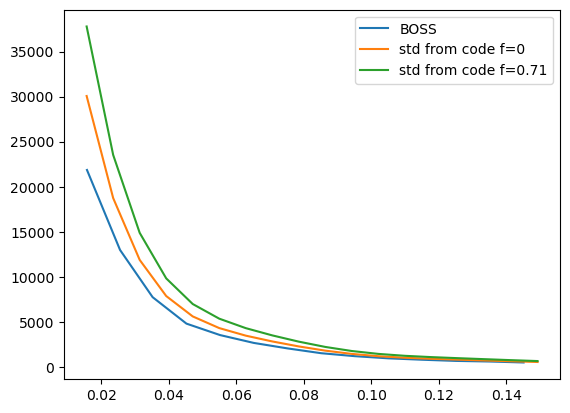

In [206]:
plt.plot(k2_boss, sigma2_boss, label='BOSS')
plt.plot(k, std_pk_Sz1[len(k):], label='std from code f=0')
plt.plot(k, std_pk_Sz1_f[len(k):], label='std from code f=0.71')
plt.legend()

## SGC Z3

In [207]:
nd_sgz3 = 0.000121
n_obj_sgz3= 158262
V_sgz3 = n_obj_sgz3/nd_sgz3

In [208]:
filename = '../BOSS_results/public_material_RSD/Beutleretal_pk_monopole_DR12_SGC_z3_prerecon_120.dat'

In [209]:
data = np.loadtxt(filename, skiprows=30)

In [210]:
k_boss = data[:,0]
P_boss = data[:,2]
sigma_boss = data[:,3]

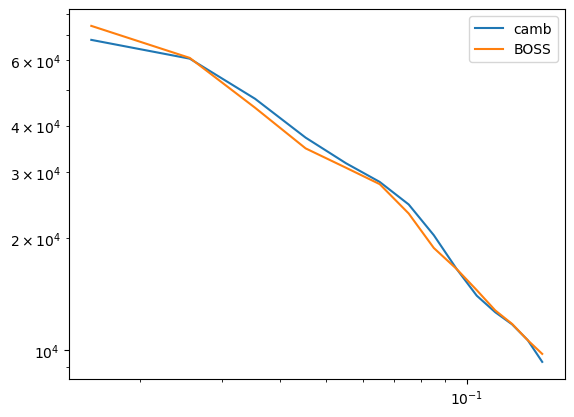

In [211]:
b1 = 2.0
plt.loglog(k_boss, b1**2*P(k_boss), label='camb')
plt.loglog(k_boss, P_boss, label='BOSS')
plt.legend()

In [212]:
f = 0
#beta = f/b1

p_k_mu = lambda k, mu : (b1 + f * mu**2) **2 * P(k)

In [220]:
f1 = 0.71
b = 1.89

p_k_mu_f = lambda k, mu : (b + f1 * mu**2) **2 * P(k)

In [221]:
cov_pk_Sz3 = PowerSpectrumGaussianCovariance(k_edges, l_list, deg=51)(p_k_mu, V_sgz3, nd_sgz3) 

/home/lentini/miniconda3/envs/pk/lib/python3.9/site-packages/GaussianCovariance/gaussian_covariance.py:84: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 2 * (2 * np.pi) ** 4 * quad(integrand, k_min, k_max, epsrel=1.e-4, epsabs=0)[0] / k_volume ** 2


In [222]:
cov_pk_Sz3_f = PowerSpectrumGaussianCovariance(k_edges, l_list, deg=51)(p_k_mu_f, V_sgz3, nd_sgz3)

In [223]:
std_pk_Sz3 = np.sqrt(np.diag(cov_pk_Sz3))
std_pk_Sz3_f = np.sqrt(np.diag(cov_pk_Sz3_f))

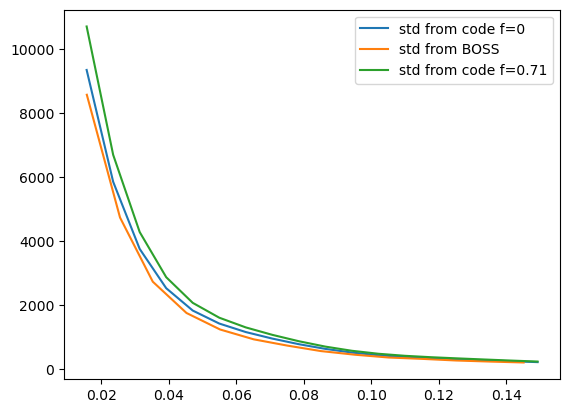

In [224]:
plt.plot(k, std_pk_Sz3[:len(k)], label='std from code f=0')
plt.plot(k_boss, sigma_boss, label='std from BOSS')
plt.plot(k, std_pk_Sz3_f[:len(k)], label='std from code f=0.71')
plt.legend()

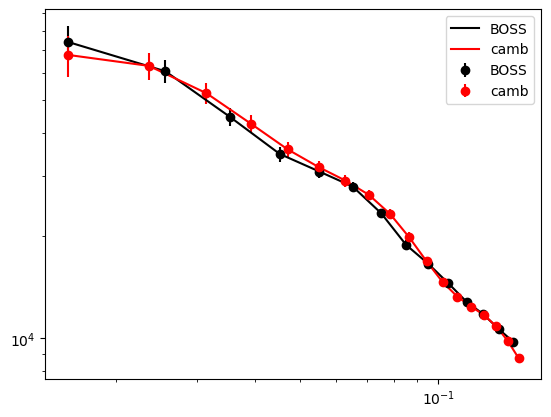

In [225]:
plt.errorbar(k_boss, P_boss, yerr=sigma_boss, fmt='o', label='BOSS', color='black')
plt.errorbar(k, b1**2*P(k), yerr=std_pk_Sz3[:len(k)], fmt='o', label='camb', color='red')
plt.plot(k_boss, P_boss, label='BOSS', color='black')
plt.plot(k, b1**2*P(k), label='camb', color='red')

plt.xscale('log')
plt.yscale('log')
plt.legend()

# QUADRUPOLE

In [230]:
filename = '../BOSS_results/public_material_RSD/Beutleretal_pk_quadrupole_DR12_SGC_z3_prerecon_120.dat'

In [231]:
data = np.loadtxt(filename, skiprows=30)

In [232]:
k2_boss = data[:,0]
P2_boss = data[:,2]
sigma2_boss = data[:,3]

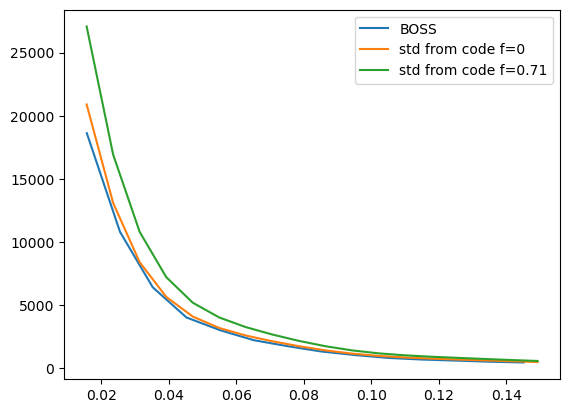

In [234]:
plt.plot(k2_boss, sigma2_boss, label='BOSS')
plt.plot(k, std_pk_Sz3[len(k):], label='std from code f=0')
plt.plot(k, std_pk_Sz3_f[len(k):], label='std from code f=0.71')
plt.legend()

## XI Covariance -> NORD+SUD

# Z1

In [261]:
V_z1 = V_ngz1 + V_sgz1

In [262]:
nd_z1 = 2.7e-4

In [263]:
b1 = 2.1
f = 0.7
#beta = f/b1

p_k_mu = lambda k, mu : (b1 + f * mu**2) **2 * P(k)

In [264]:
cov_xi_z1 = xi_covariance(p_k_mu, V_z1, nd_z1)

Computing tabulated sigma squared...
Done!


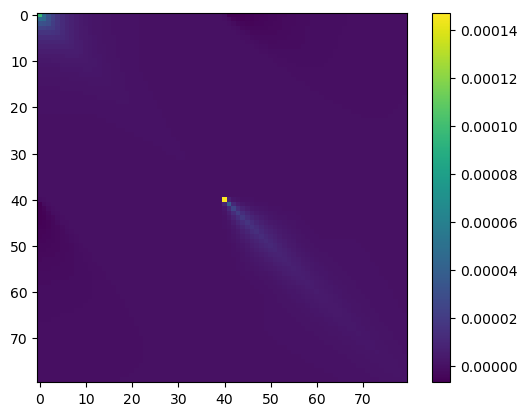

In [265]:
plt.imshow(cov_xi_z1, cmap = 'viridis')
plt.colorbar()

In [266]:
filename = '../../xi/BOSS_results/Satpathy_2016_COMBINEDDR12_Bin1_Covariance_pre_recon.txt'

In [267]:
cov_xi_z1_boss = np.loadtxt(filename)

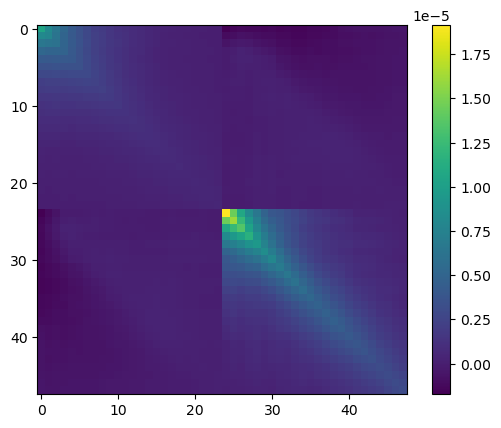

In [268]:
plt.imshow(cov_xi_z1_boss, cmap = 'viridis')
plt.colorbar()

In [269]:
std_xi_z1 = np.sqrt(np.diag(cov_xi_z1))

In [270]:
std_xi_z1_boss = np.sqrt(np.diag(cov_xi_z1_boss))

In [271]:
r_boss = np.arange(25, 150 ,5)

In [272]:
r_boss

array([ 25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,  85,
        90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145])

In [273]:
#I consider the r_bins in the same range as the BOSS data
r_bins[30]

152.5

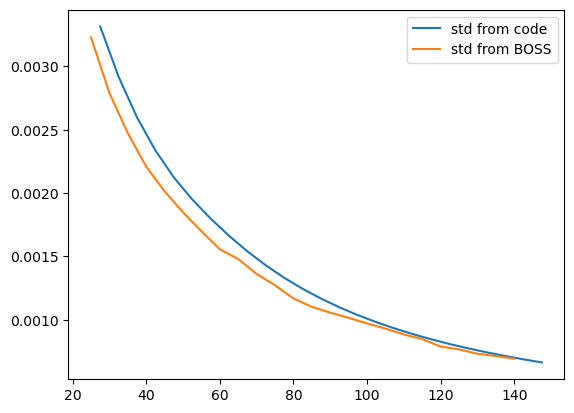

In [274]:
plt.plot(r_bins[5:30], std_xi_z1[5:30], label='std from code')
plt.plot(r_boss[:-1], std_xi_z1_boss[:24], label='std from BOSS')
plt.legend()

# Z3

In [275]:
V_z3 = V_ngcz3 + V_sgz3

In [276]:
nd_z3 = 1.2e-4

In [277]:
b1 = 2.1
f = 0.7
#beta = f/b1

p_k_mu = lambda k, mu : (b1 + f * mu**2) **2 * P(k)

In [278]:
cov_xi_z3 = xi_covariance(p_k_mu, V_z3, nd_z3)

Computing tabulated sigma squared...
Done!


In [279]:
filename = '../../xi/BOSS_results/Satpathy_2016_COMBINEDDR12_Bin3_CovarianceMatrix_pre_recon.txt'

In [280]:
cov_xi_z3_boss = np.loadtxt(filename)

In [281]:
std_xi_z3 = np.sqrt(np.diag(cov_xi_z3))

In [282]:
std_xi_z3_boss = np.sqrt(np.diag(cov_xi_z3_boss))

In [283]:
r_boss = np.arange(25, 150 ,5)

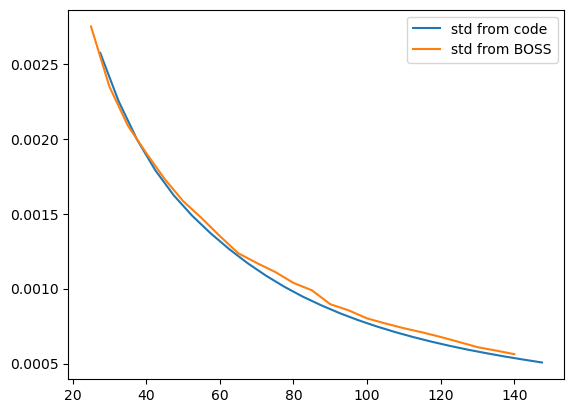

In [284]:
plt.plot(r_bins[5:30], std_xi_z3[5:30], label='std from code')
plt.plot(r_boss[:-1], std_xi_z3_boss[:24], label='std from BOSS')
plt.legend()

SAVE THE COV

In [395]:
#np.save('../Covariance_matrix/cov_pk_Nz1.npy', cov_pk_Nz1)
#np.save('../Covariance_matrix/cov_pk_Nz3.npy', cov_pk_Nz3)
#np.save('../Covariance_matrix/cov_pk_Sz1.npy', cov_pk_Sz1)
#np.save('../Covariance_matrix/cov_pk_Sz3.npy', cov_pk_Sz3)
#np.save('../Covariance_matrix/cov_xi_z1.npy', cov_xi_z1)
#np.save('../Covariance_matrix/cov_xi_z3.npy', cov_xi_z3)